# 尝试在乔哥的图片上找到黑白两色的颗粒

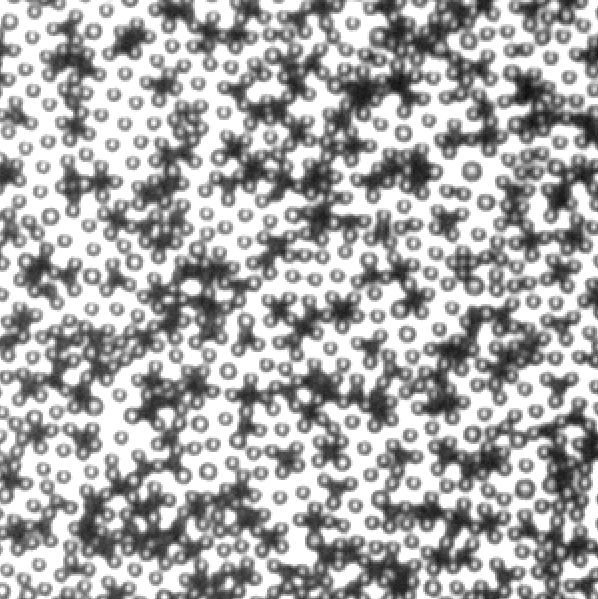

首先试了试ImageJ的Trackmate插件，用LoG方法（7 pixel，threshold 10）可以得到如下效果。这个方法两色的颗粒都能找到一些，但黑色颗粒位置相对准确，白色颗粒位置有些偏，原因是这个方法是在图片里找类似gaussian的峰，所以白色的颗粒的边缘会被当做中心。所以我们可以基于这个方法的结果，挑选出黑色颗粒，即在下图中亮度总和高的区域。白色区域则用一个类似Mexican hat的图案重新找出。

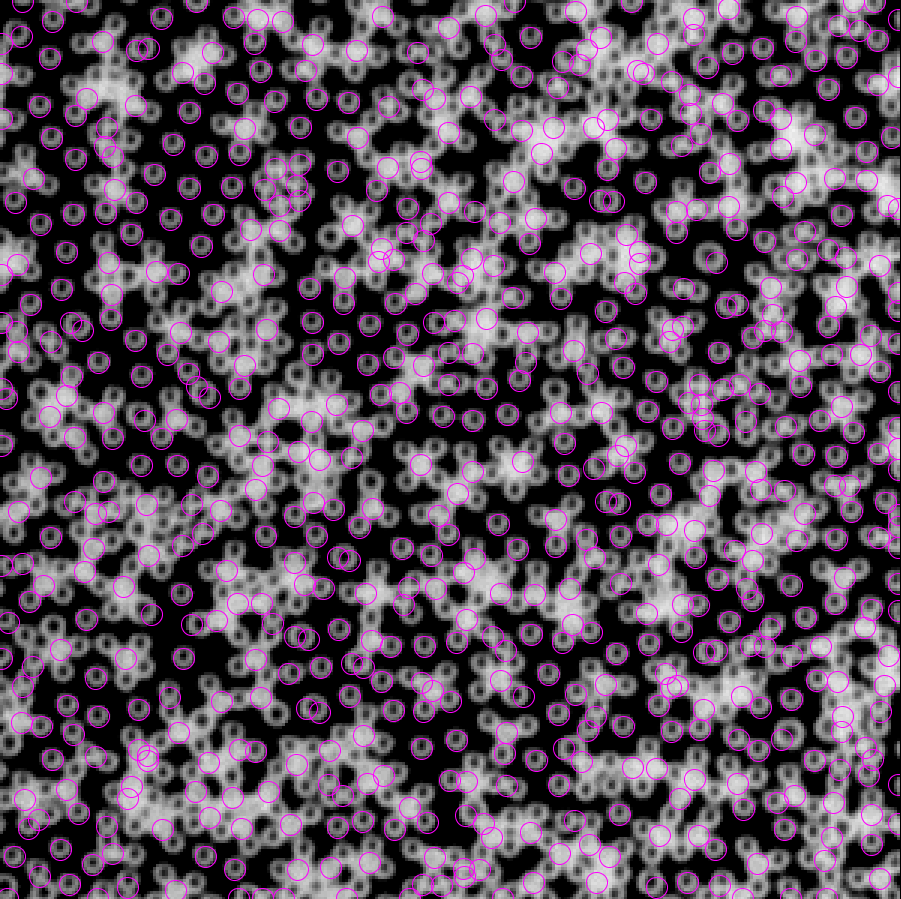

## 1 用Python代码实现TrackMate的LoG方法（非完全复现，没有细节，只有基本思路）。

In [2]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

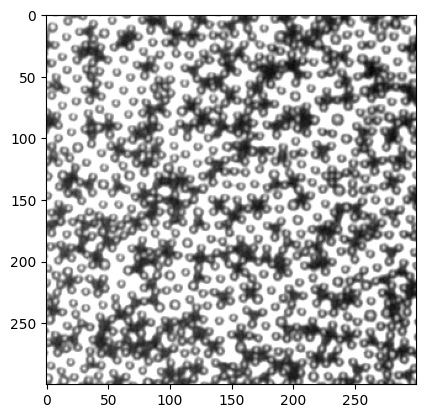

In [3]:
img = io.imread("try0000_imj.tif")
plt.imshow(img, cmap="gray")

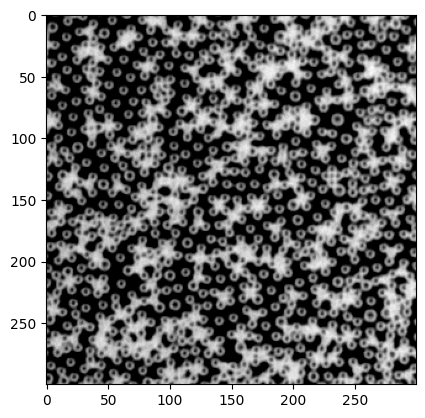

In [4]:
# invert image
inv_img = 255 - img
plt.imshow(inv_img, cmap="gray")

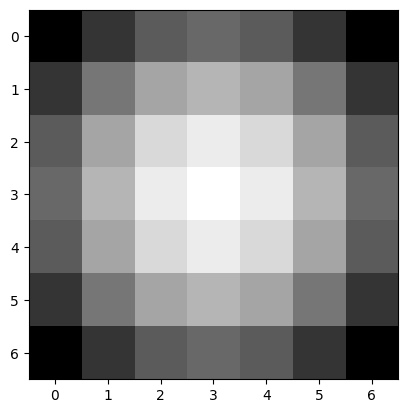

In [39]:
# generate a gaussian mask 
from myImageLib import matlab_style_gauss2D
# matlab_style_gauss2D(shape=(3,3),sigma=0.5)
gauss_mask = matlab_style_gauss2D(shape=(7,7),sigma=3.5)
plt.imshow(gauss_mask, cmap="gray")

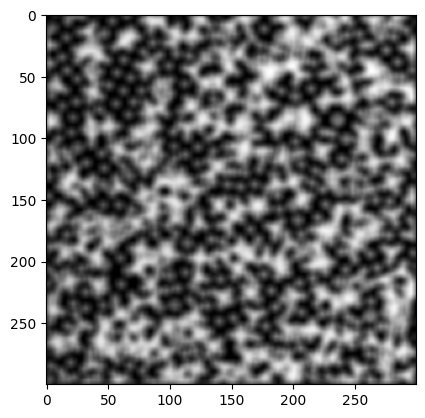

In [40]:
# treat the image with the mask first
from scipy.signal import convolve2d
timg = convolve2d(inv_img, gauss_mask, mode="same")
plt.imshow(timg, cmap="gray")

In [41]:
gauss_mask.shape

(7, 7)

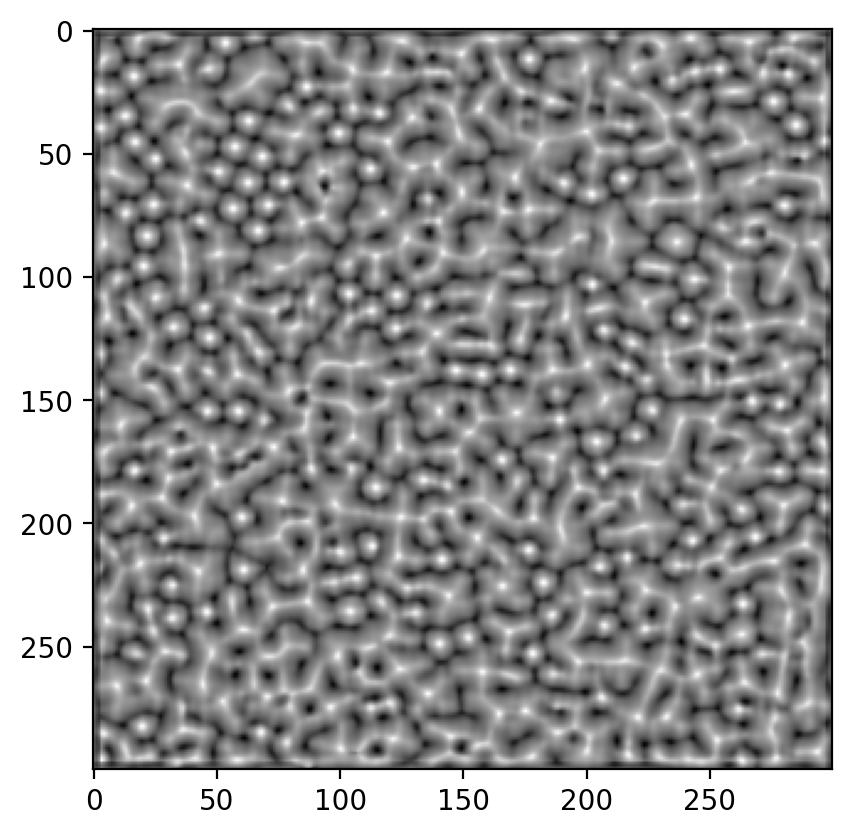

In [42]:
# compute correlation map between inv_img and gauss_mask
from xcorr_funcs import normxcorr2
corr = normxcorr2(gauss_mask, timg, "same")
plt.figure(dpi=200)
plt.imshow(corr, cmap="gray")

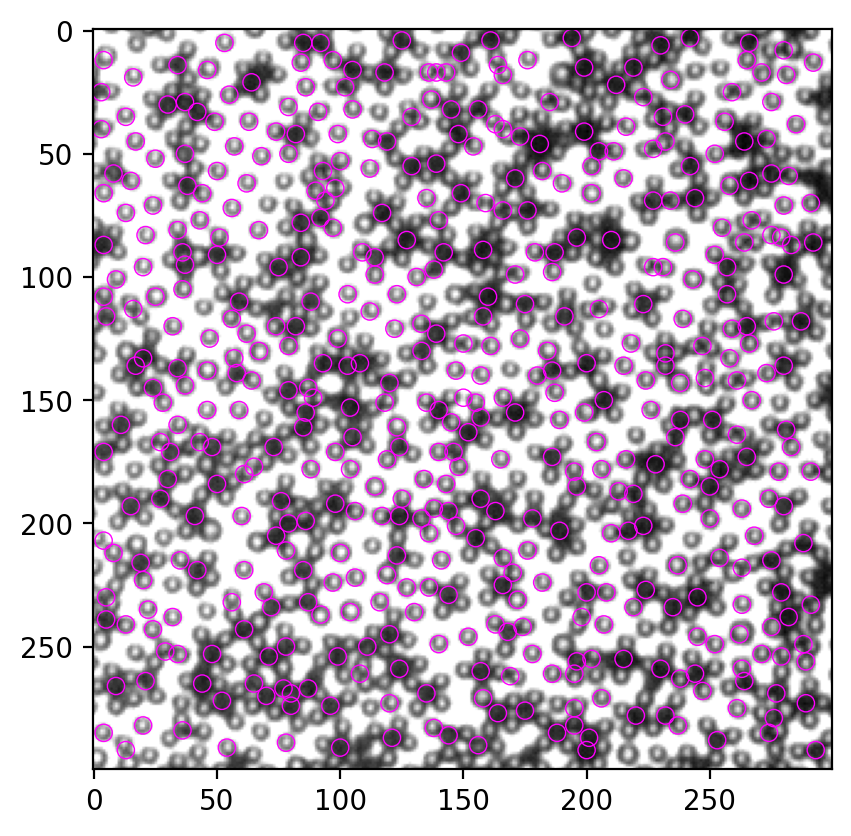

In [49]:
# find peaks on the correlation map corr
from xcorr_funcs import FastPeakFind
from matplotlib.patches import Circle
peak = FastPeakFind(corr)
fig, ax = plt.subplots(dpi=200)
ax.imshow(img, cmap="gray")
for y, x in peak.T:
    circ = Circle((x, y), radius=3.5, ec="magenta", fill=False, lw=0.5)
    ax.add_patch(circ)

Put the TrackMate result and Python result side by side. It's not a faithful replication, but I think most black particles are correctly located.

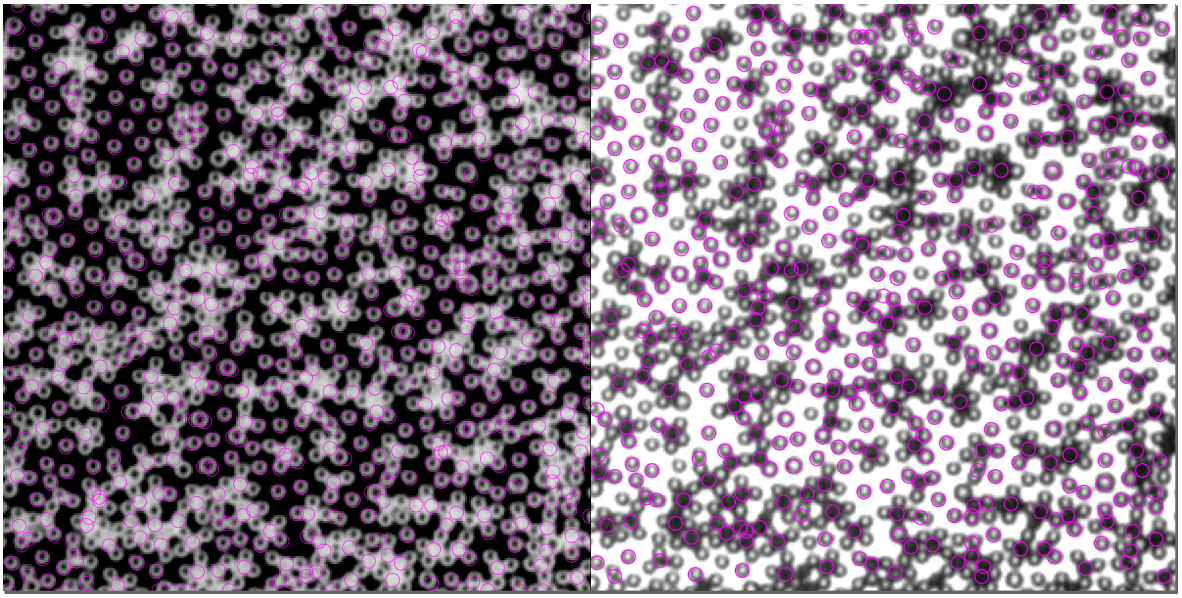

# 2 区分黑白颗粒

第一个想法是看找到的颗粒里的像素值总和，黑颗粒应该远小于白颗粒。

In [46]:
# generate coords matrices
img = io.imread("try0000_imj.tif")
Y, X = np.mgrid[0:img.shape[0], 0:img.shape[1]]

In [51]:
# iterate over all the detected particle coords, compute total pixel values
R = 3.5
pixel_sum_list = []
for y, x in peak.T:
    mask = (X - x) ** 2 + (Y - y) ** 2 < R ** 2
    pv = img[mask].sum()
    pixel_sum_list.append(pv)

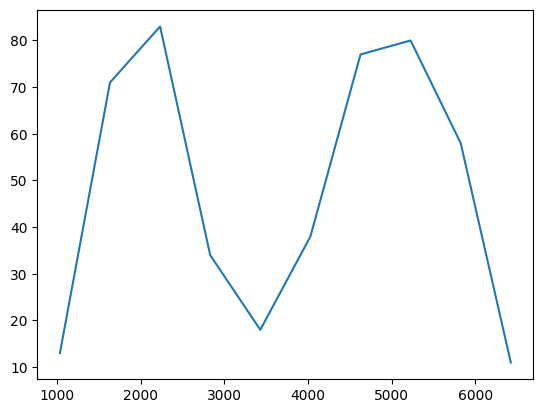

In [53]:
# histogram of pixel values, expect a binodal distribution
hist, bin_edges = np.histogram(np.array(pixel_sum_list))
plt.plot(bin_edges[:-1], hist)

确实是两个峰，非常beautiful。我们的目标是找黑色particle，所以取第一个峰内的所有点即可。这里我手动设置一个阈值3500，作为两个峰的分界点，取所有像素值总和在3500以下的颗粒作为黑色颗粒。

In [56]:
# for my convenience, I genenerate a DataFrame to manipulate the data
import pandas as pd
particles = pd.DataFrame({"x": peak[1], "y": peak[0], "pv": pixel_sum_list})

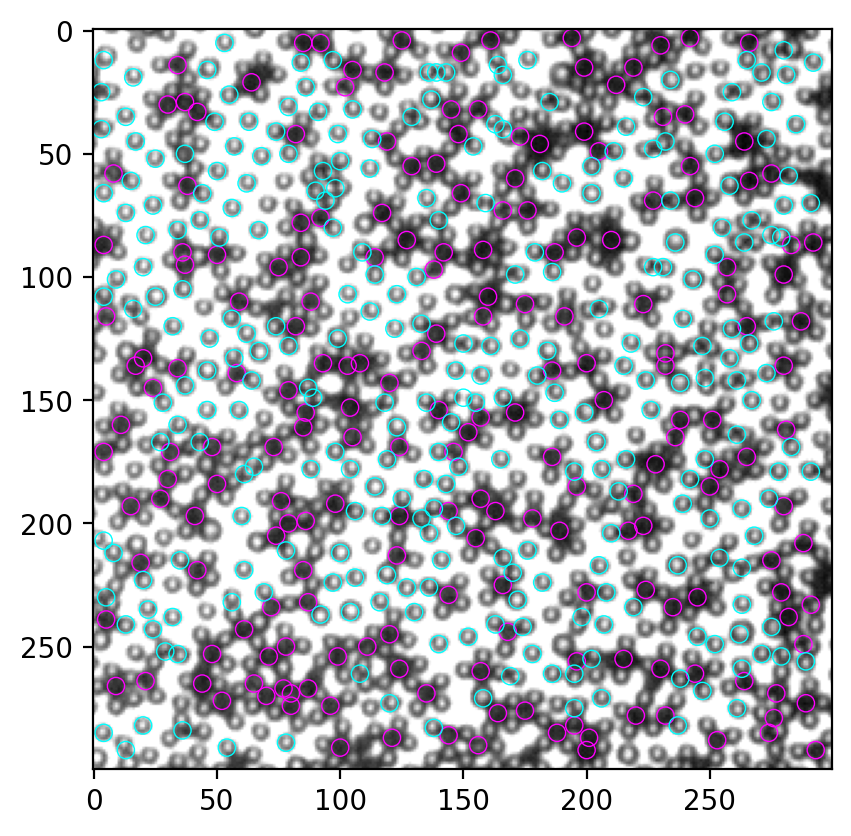

In [61]:
thres = 3500
black = particles.loc[particles.pv<=thres]
other = particles.loc[particles.pv>thres]

fig, ax = plt.subplots(dpi=200)
ax.imshow(img, cmap="gray")
for num, i in black.iterrows():
    circ = Circle((i.x, i.y), radius=3.5, ec="magenta", fill=False, lw=0.5)
    ax.add_patch(circ)
for num, i in other.iterrows():
    circ = Circle((i.x, i.y), radius=3.5, ec="cyan", fill=False, lw=0.5)
    ax.add_patch(circ)

# 3 寻找白色颗粒

尽管我们上一节找到了部分白色颗粒，但找到的数量大概不到总数的一半，还有提高的空间。这里尝试用Mexican hat为模板寻找。

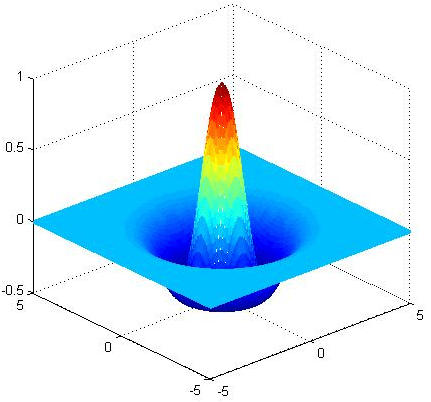

[Ricker wavelet](https://en.wikipedia.org/wiki/Ricker_wavelet)

In [75]:
# Generate a Mexican hat shape mask
def mexican_hat(shape=(3,3), sigma=1):
    """
    2D mexican hat mask
    """
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]
    h = 1 / np.pi / sigma ** 4 * (1 - (x*x + y*y) / (2*sigma*sigma)) * np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


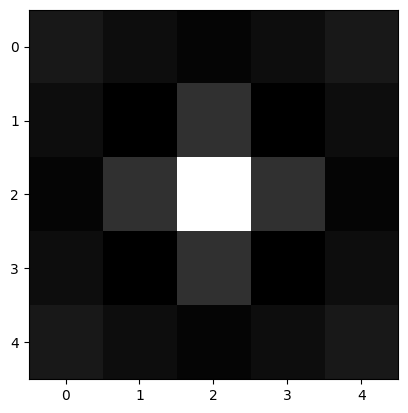

In [130]:
mh = mexican_hat(shape=(5,5), sigma=0.8)
plt.imshow(mh, cmap="gray")

我们重复第二节的流程：
- convolve image and mask
- correlate image and mask
- find peak in correlation map

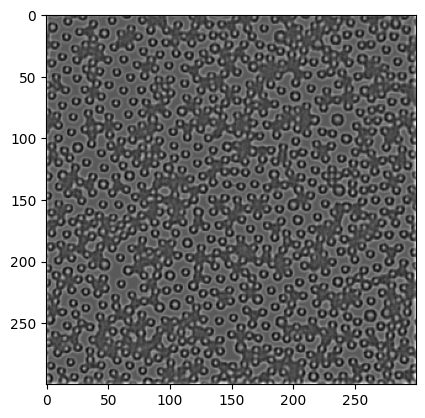

In [131]:
timg = convolve2d(img, mh, mode="same")
plt.imshow(timg, cmap="gray") 

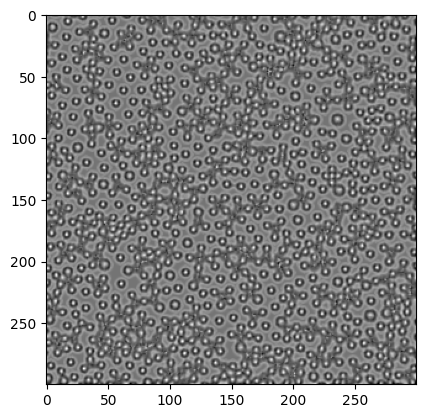

In [140]:
corr = normxcorr2(mh, img, "same")
plt.imshow(corr, cmap="gray")
io.imsave("corr.tif", corr)

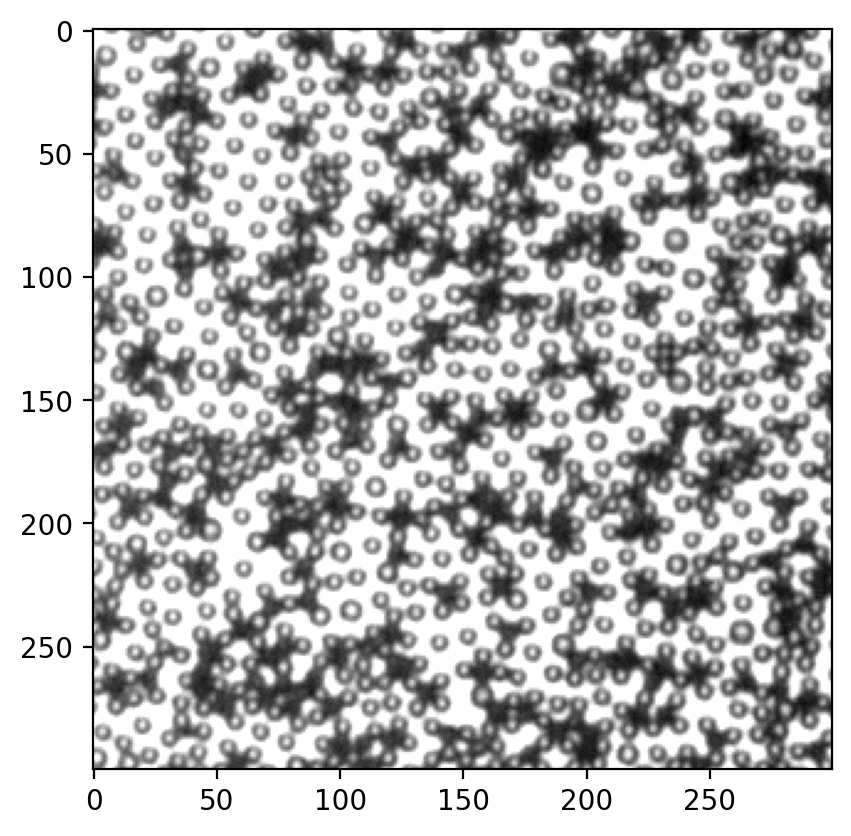

In [141]:
peak = FastPeakFind(-corr)
# corr = convolve2d(corr, gauss_mask)
fig, ax = plt.subplots(dpi=200)
ax.imshow(img, cmap="gray")
for y, x in peak.T:
    circ = Circle((x, y), radius=3.5, ec="magenta", fill=False, lw=0.5)
    ax.add_patch(circ)

不清楚为什么FaskPeakFind不好用。但是在correlation map上的白色particle肉眼都可以清楚看见。我截图在ImageJ里尝试找局部最大，效果如下：

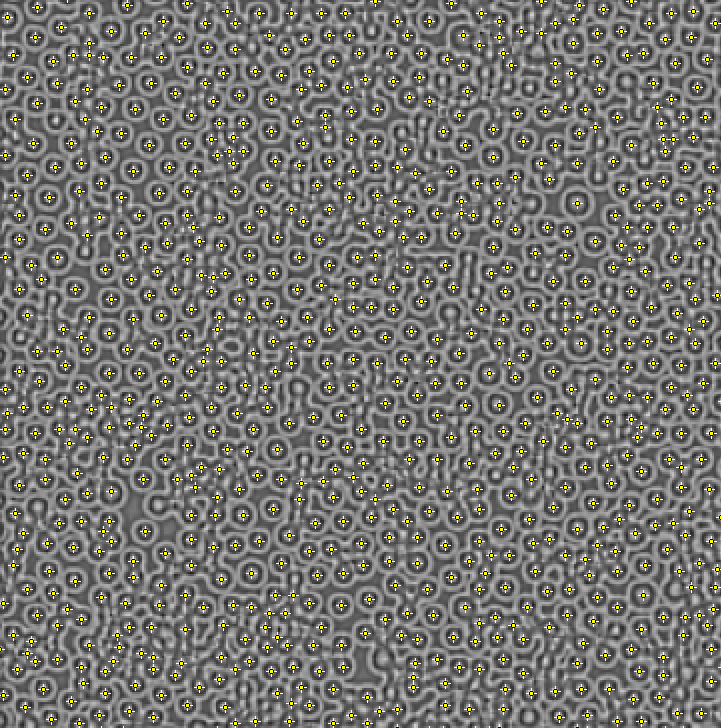

下面导入local maxima数据，画在原图上。

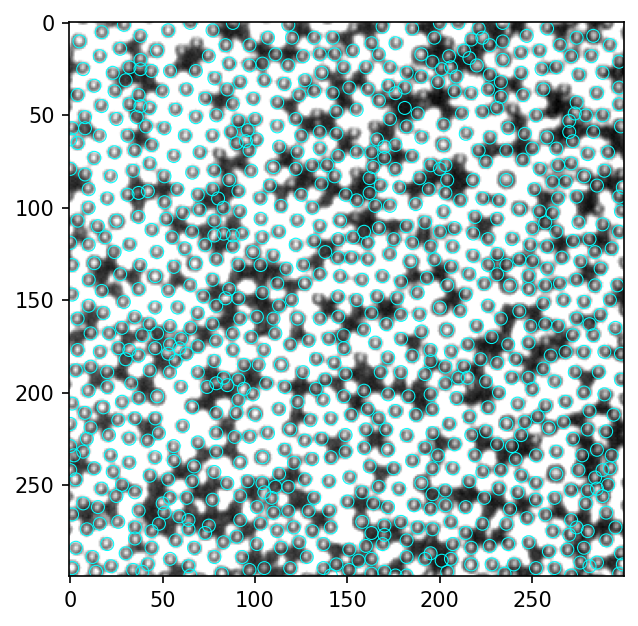

In [142]:
data = pd.read_csv("local_maxima.csv")
fig, ax = plt.subplots(dpi=150)
ax.imshow(img, cmap="gray")
for num, i in data.iterrows():
    circ = Circle((i.X, i.Y), radius=3.5, ec="cyan", fill=False, lw=0.5)
    ax.add_patch(circ)

看起来绝大部分的白色particle都找到了，至少是多余90%。这是在imagej里找local maxima的结果，需要调整一个参数“prominence”。这里尝试在用python复现local maxima。

In [154]:
from skimage.feature import peak_local_max
coordinates = peak_local_max(corr, min_distance=5)

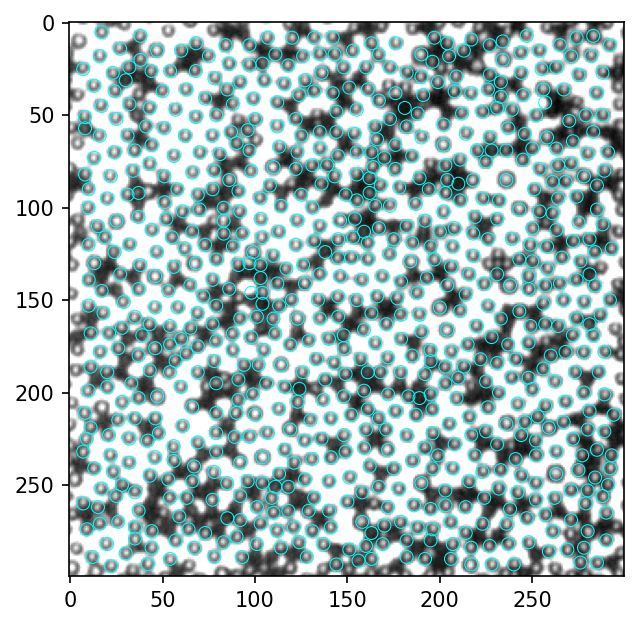

In [155]:
fig, ax = plt.subplots(dpi=150)
ax.imshow(img, cmap="gray")
for y, x in coordinates:
    circ = Circle((x, y), radius=3.5, ec="cyan", fill=False, lw=0.5)
    ax.add_patch(circ)

In [149]:
data.shape

(848, 3)

In [153]:
coordinates.shape

(973, 2)

ImageJ和Python的findmaxima效果都能接受，但ImageJ的更好。我试着找过有没有人把ImageJ的算法用python实现，[唯一找到的code](https://github.com/dwaithe/MaximaFinder)安装不了，我提交了一个issue看看能不能解决，现阶段就用`from skimage.feature import peak_local_max`。如果需要更好的结果，可以把图片处理好再用imagej找，比较麻烦，视需求决定。

## 4 全部流程整合

In [8]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from myImageLib import to8bit, matlab_style_gauss2D
from scipy.signal import convolve2d
from xcorr_funcs import normxcorr2, FastPeakFind
from matplotlib.patches import Circle
import pandas as pd
from skimage.feature import peak_local_max

(-0.5, 299.5, 299.5, -0.5)

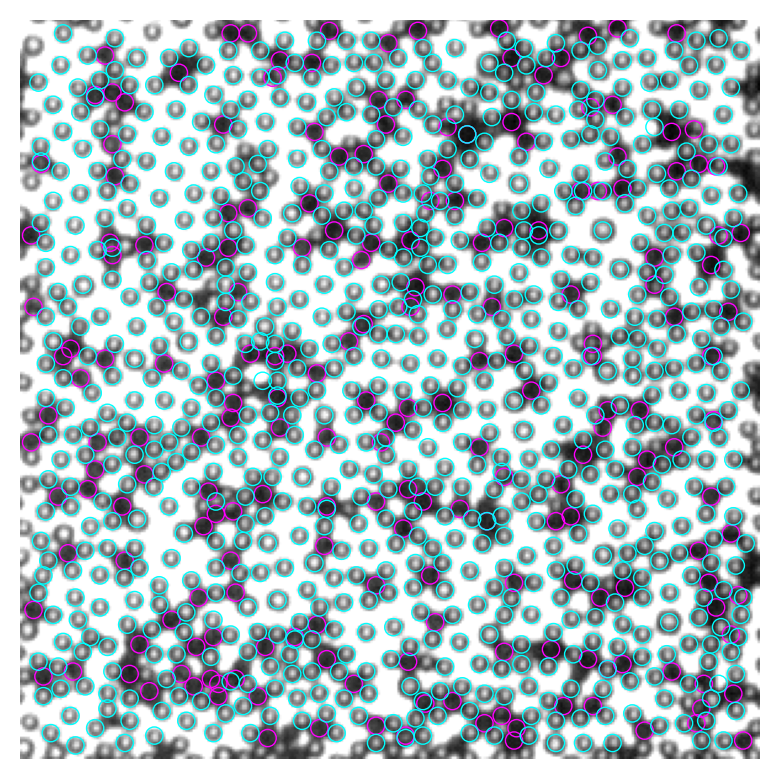

In [10]:
# find black particles
img = io.imread("try0000_imj.tif")
img = to8bit(img)
inv_img = 255 - img
gauss_mask = matlab_style_gauss2D(shape=(7,7),sigma=3.5) # 这里的shape是particle的直径，单位px
timg = convolve2d(inv_img, gauss_mask, mode="same") 
corr = normxcorr2(gauss_mask, timg, "same") # 找匹配mask的位置
peak = FastPeakFind(corr) # 无差别找峰
# 计算mask内的像素值之和
Y, X = np.mgrid[0:img.shape[0], 0:img.shape[1]] 
R = 3.5 
pixel_sum_list = []
for y, x in peak.T:
    mask = (X - x) ** 2 + (Y - y) ** 2 < R ** 2
    pv = img[mask].sum()
    pixel_sum_list.append(pv)
# 把数据装进一个DataFrame
particles = pd.DataFrame({"x": peak[1], "y": peak[0], "pv": pixel_sum_list})

thres = 3500 # 手动设定阈值
black = particles.loc[particles.pv<=thres]
other = particles.loc[particles.pv>thres]

#把黑色particle画在原图上
fig, ax = plt.subplots(dpi=200)
ax.imshow(img, cmap="gray")
for num, i in black.iterrows():
    circ = Circle((i.x, i.y), radius=3.5, ec="magenta", fill=False, lw=0.5)
    ax.add_patch(circ)
    
# 找白
def mexican_hat(shape=(3,3), sigma=1):
    """
    2D mexican hat mask
    """
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]
    h = 1 / np.pi / sigma ** 4 * (1 - (x*x + y*y) / (2*sigma*sigma)) * np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

mh = mexican_hat(shape=(5,5), sigma=0.8) # 这里shape和上面同理，sigma需要自行尝试一下，1左右
timg = convolve2d(img, mh, mode="same")
corr = normxcorr2(mh, img, "same")
coordinates = peak_local_max(corr, min_distance=5) 
for y, x in coordinates:
    circ = Circle((x, y), radius=3.5, ec="cyan", fill=False, lw=0.5)
    ax.add_patch(circ)
ax.axis("off")